In [3]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np

from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

In [132]:
batch_size = 100
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 400
latent_dim= 15
de_hidden1_dim = 400
log_interval = 10

K_model_cluster = 10



In [ ]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

In [72]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)
        self.mu_layer = nn.Linear(en_hidden1_dim,latent_dim)
        self.std_layer = nn.Linear(en_hidden1_dim,latent_dim)
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)
        self.output_layer = nn.Linear(de_hidden1_dim,output_dim)

    def encode(self, x):
        h1 = F.relu(self.input_layer(x))
        return self.mu_layer(h1), self.std_layer(h1)
    #入力から中心と分散の対数を作っている

    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は等方的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        h3 = F.relu(self.decode1_layer(z))
        return torch.sigmoid(self.output_layer(h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [73]:
def loss_function(recon_x,x,mu,logvar):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    #recon_xはsigmoidをdecordeで通されているので、[0,1]になっている。
    KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())

    return BCE+KLD

In [74]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [75]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function(recon_batch,data,mu,logvar).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./results/reconstruction_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [76]:
epochs = 10
for epoch in range(1, epochs +1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
        sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
        save_image(sample.view(64,1,28,28),'results/sample_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


Train Epoch: 1 [0/60000 (0%)]	Loss: 549.123242
Train Epoch: 1 [1000/60000 (2%)]	Loss: 314.406387
Train Epoch: 1 [2000/60000 (3%)]	Loss: 240.244512
Train Epoch: 1 [3000/60000 (5%)]	Loss: 225.325781
Train Epoch: 1 [4000/60000 (7%)]	Loss: 222.012266
Train Epoch: 1 [5000/60000 (8%)]	Loss: 216.436113
Train Epoch: 1 [6000/60000 (10%)]	Loss: 202.669961
Train Epoch: 1 [7000/60000 (12%)]	Loss: 198.753906
Train Epoch: 1 [8000/60000 (13%)]	Loss: 190.746621
Train Epoch: 1 [9000/60000 (15%)]	Loss: 191.243535
Train Epoch: 1 [10000/60000 (17%)]	Loss: 191.539453
Train Epoch: 1 [11000/60000 (18%)]	Loss: 182.237246
Train Epoch: 1 [12000/60000 (20%)]	Loss: 185.148496
Train Epoch: 1 [13000/60000 (22%)]	Loss: 170.769961
Train Epoch: 1 [14000/60000 (23%)]	Loss: 167.998633
Train Epoch: 1 [15000/60000 (25%)]	Loss: 165.640977
Train Epoch: 1 [16000/60000 (27%)]	Loss: 158.055449
Train Epoch: 1 [17000/60000 (28%)]	Loss: 154.618437
Train Epoch: 1 [18000/60000 (30%)]	Loss: 156.330713
Train Epoch: 1 [19000/60000 (32

In [4]:
fig = plt.figure(figsize=(10,3))
model.eval()

NameError: name 'model' is not defined

<Figure size 720x216 with 0 Axes>

In [2]:
#zs = torch.empty(0,0)
zs = []
ts = []

#ts.dtype = torch.int

for x, t in test_loader:
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
    x = x.to(device)
    recon_batch,mu,logvar, z = model(x)

    zs.append(z)
    ts.append(t)
    #zs = torch.cat((zs,z),0)
    #ts = torch.cat()
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')



NameError: name 'test_loader' is not defined

In [78]:
zs = torch.cat(zs,dim=0)
ts = torch.cat(ts).requires_grad_(False)

In [79]:
zs,ts

(tensor([[-0.4905, -0.2805, -0.0446,  ..., -2.3959,  0.0245, -1.3829],
         [-1.7825, -0.3654,  0.8204,  ..., -0.3602, -0.3800, -0.3705],
         [-1.2430,  1.8309,  1.7012,  ..., -0.0859, -0.9251,  0.0201],
         ...,
         [-0.8920, -0.8641, -0.6110,  ..., -0.5500, -0.4289,  1.3393],
         [-1.1756, -1.8284, -1.1134,  ..., -1.3762, -1.0149,  0.3092],
         [-1.3374, -0.5742,  0.6004,  ...,  0.9314,  2.1553, -0.0411]],
        device='cuda:0', grad_fn=<CatBackward>),
 tensor([4, 9, 9,  ..., 0, 7, 3]))

In [80]:
zs_numpy = zs.cpu().detach().numpy()
zs_numpy

array([[-0.49047828, -0.28049427, -0.04461914, ..., -2.3959363 ,
         0.0245263 , -1.3829441 ],
       [-1.7825425 , -0.36536008,  0.8204489 , ..., -0.36017844,
        -0.38001698, -0.3704733 ],
       [-1.2429876 ,  1.8309377 ,  1.7011689 , ..., -0.08594556,
        -0.9250785 ,  0.02011232],
       ...,
       [-0.8919953 , -0.864053  , -0.61100453, ..., -0.5500079 ,
        -0.42885724,  1.3392859 ],
       [-1.1755602 , -1.8284112 , -1.1133807 , ..., -1.3762292 ,
        -1.0148839 ,  0.30921355],
       [-1.337357  , -0.57416755,  0.6003666 , ...,  0.9313927 ,
         2.155287  , -0.04108204]], dtype=float32)

In [81]:
points = TSNE(n_components=2,random_state=0).fit_transform(zs_numpy)
points

array([[ 48.224693, -42.370045],
       [  3.55752 , -49.90532 ],
       [ 14.37715 , -43.84704 ],
       ...,
       [ 56.686348,   5.182107],
       [-18.988045, -63.662846],
       [-15.701626,  50.51029 ]], dtype=float32)

In [82]:
ts_numpy = ts.cpu().detach().numpy()
ts_numpy

array([4, 9, 9, ..., 0, 7, 3])

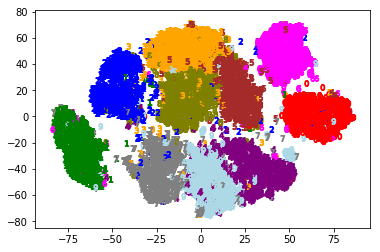

In [83]:
colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
for p,l in zip(points,ts_numpy):
    plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

In [84]:
gauss_model = GaussianMixture(n_components=10,covariance_type='full',random_state=1)
gauss_model.fit(zs_numpy)
ls = gauss_model.predict(zs_numpy)

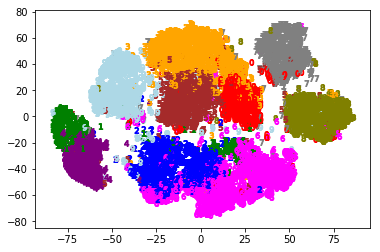

In [85]:
for p,l in zip(points,ls):
    plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

In [86]:
gauss_model_2d = GaussianMixture(n_components=10,covariance_type='full',random_state=1)
gauss_model_2d.fit(points)
ls_2d = gauss_model_2d.predict(points)

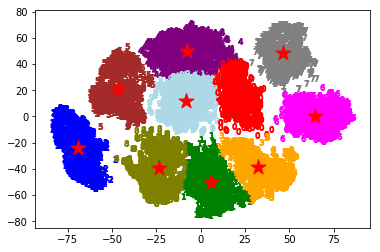

In [87]:
for p,l in zip(points,ls_2d):
    plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])
plt.scatter(gauss_model_2d.means_[:,0],gauss_model_2d.means_[:,1],s=250,marker='*',c='red')

In [88]:
zs

tensor([[-0.4905, -0.2805, -0.0446,  ..., -2.3959,  0.0245, -1.3829],
        [-1.7825, -0.3654,  0.8204,  ..., -0.3602, -0.3800, -0.3705],
        [-1.2430,  1.8309,  1.7012,  ..., -0.0859, -0.9251,  0.0201],
        ...,
        [-0.8920, -0.8641, -0.6110,  ..., -0.5500, -0.4289,  1.3393],
        [-1.1756, -1.8284, -1.1134,  ..., -1.3762, -1.0149,  0.3092],
        [-1.3374, -0.5742,  0.6004,  ...,  0.9314,  2.1553, -0.0411]],
       device='cuda:0', grad_fn=<CatBackward>)

In [114]:
zs.size()[0]

10000

In [128]:
mu_original= zs.mean(0).detach().requires_grad_(False)
mu_original

tensor([-0.0596, -0.1282,  0.0019,  0.1194, -0.0830, -0.1153, -0.0868,  0.0285,
         0.0074,  0.1296,  0.0215, -0.0733, -0.0253, -0.0211,  0.0046],
       device='cuda:0')

In [137]:
mu_original.cuda()

tensor([-0.0596, -0.1282,  0.0019,  0.1194, -0.0830, -0.1153, -0.0868,  0.0285,
         0.0074,  0.1296,  0.0215, -0.0733, -0.0253, -0.0211,  0.0046],
       device='cuda:0')

In [412]:
data_white = zs-mu_original
cov_original = torch.matmul(data_white.transpose(1,0),data_white)/zs.size()[0]
cov_original = cov_original.clone().detach().requires_grad_(False)
cov_original

tensor([[ 1.0551e+00,  7.0268e-02,  1.3406e-02, -1.8490e-01,  1.7133e-01,
          3.3581e-02, -1.5086e-02,  8.9963e-02,  6.1068e-02,  9.2680e-03,
          1.3314e-01,  2.0842e-02,  2.9111e-02, -6.8602e-03, -1.2044e-01],
        [ 7.0268e-02,  1.0962e+00,  5.2261e-02, -2.5125e-02,  5.7297e-02,
          2.2981e-02,  1.8614e-01,  1.6041e-01, -5.6086e-02, -7.5862e-02,
         -7.5599e-03, -8.6385e-02,  1.7051e-01,  1.1094e-02,  1.3237e-01],
        [ 1.3406e-02,  5.2261e-02,  9.5845e-01, -5.5771e-03,  2.3919e-02,
         -1.3324e-02,  4.7681e-03,  5.1583e-02,  2.6575e-02, -4.5798e-02,
         -2.3289e-02, -2.1912e-02, -1.4658e-02,  3.6189e-02,  4.9550e-02],
        [-1.8490e-01, -2.5125e-02, -5.5771e-03,  1.0367e+00, -4.4557e-02,
          1.9842e-02,  9.1676e-03,  3.0159e-02, -2.0681e-01,  1.3176e-01,
         -2.6507e-02,  3.5983e-02, -4.1872e-02,  1.9795e-02, -2.6665e-02],
        [ 1.7133e-01,  5.7297e-02,  2.3919e-02, -4.4557e-02,  1.0699e+00,
          1.9471e-03, -1.4069e-02,

In [413]:
original_distribution = MultivariateNormal(mu_original.cpu(),cov_original.cpu())

mu_k = original_distribution.sample([K_model_cluster,]).requires_grad_(False)
mu_k

tensor([[ 1.1689,  0.9606, -0.5128, -1.5010, -0.5457,  1.7522, -0.5057,  2.0172,
         -0.2869, -0.2446, -0.4845, -0.1582,  0.3418, -0.7746, -1.3735],
        [ 0.1148, -1.1403, -0.8479,  1.2854, -0.4171, -0.4058,  0.1369,  1.0365,
         -1.6410,  0.9710,  0.3963, -0.4677,  0.1300, -2.0325, -0.4910],
        [-0.3406,  1.4198, -0.1224,  1.2850,  0.6320,  0.0751, -0.9880, -1.2205,
         -1.6199, -0.3741,  1.3532, -0.7876,  1.5567,  1.3095,  1.5280],
        [-0.9498, -0.0985, -0.4016, -0.2512,  0.0811, -0.1506, -0.5037,  0.8777,
         -0.3900, -0.7305,  0.1910, -2.5302, -1.3483,  0.1943,  2.2069],
        [ 0.9963, -0.8690,  0.1169,  0.9091, -0.6560, -0.9742, -0.5198,  0.8169,
         -1.8970,  0.3599,  1.5010,  0.1022,  2.4954, -1.2187,  0.1449],
        [ 0.0615, -0.6445,  0.8982, -1.3100, -1.3158, -1.1704,  0.8407,  1.8340,
         -1.7972,  0.6880,  0.3375, -1.5165, -0.8708, -0.7622,  1.8480],
        [ 1.1669, -0.1414,  0.6525, -0.4811,  1.6604, -1.9877, -0.7359, -1.5

In [414]:
mu_k = mu_k.to(device)
mu_k.is_cuda


True

In [415]:
pi_k = torch.full((K_model_cluster,),1./K_model_cluster,requires_grad=False)
pi_k

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])

In [416]:
#cov_k = cov_original.clone().requires_grad_(True)
cov_k = 1*cov_original
cov_k = cov_k.repeat(K_model_cluster,1,1)
cov_k.shape

torch.Size([10, 15, 15])

In [640]:
N_nk = torch.empty(int(zs.size()[0]),K_model_cluster)
for i in range(K_model_cluster):
    N_nk_dist = MultivariateNormal(loc=mu_k[i].cpu(),covariance_matrix=cov_k[i].cpu())
    N_nk[:,i] = N_nk_dist.log_prob(zs.cpu()).exp()


In [641]:
pi_N_nk = pi_k*N_nk
gamma_nk = pi_N_nk/pi_N_nk.sum(1).view(-1,1)
N_k = gamma_nk.sum(0)
gamma_nk

tensor([[1.0000e+00, 9.3496e-07, 4.3324e-14,  ..., 7.4168e-10, 8.2327e-38,
         4.9790e-15],
        [1.3216e-04, 9.3533e-01, 5.9087e-02,  ..., 5.4462e-03, 2.9961e-29,
         1.5295e-21],
        [1.0830e-02, 1.5973e-02, 9.7187e-01,  ..., 1.4317e-08, 1.5144e-16,
         1.6869e-18],
        ...,
        [1.8399e-17, 2.8120e-08, 1.6453e-17,  ..., 1.2454e-07, 1.2018e-18,
         3.0107e-04],
        [4.4611e-09, 9.9834e-01, 1.5268e-03,  ..., 1.2979e-04, 0.0000e+00,
         4.2232e-09],
        [2.4303e-20, 6.3217e-07, 7.7996e-10,  ..., 4.5375e-09, 3.4577e-17,
         1.3432e-16]], grad_fn=<DivBackward0>)

In [642]:
log_P = torch.log(pi_N_nk.sum(1)).sum()/zs.size()[0]
log_P

tensor(-18.7188, grad_fn=<DivBackward0>)

In [643]:
for i in range(K_model_cluster):
    mu_k[i] = (gamma_nk[:,i].view(-1,1)*zs.cpu()).sum(0)/N_k[i]

mu_k

tensor([[-0.5086,  0.9053, -0.2387,  0.1605, -0.3471,  0.4190,  0.6074,  0.2603,
         -0.7030,  0.3028,  0.2172, -0.0684, -1.0126, -0.1231, -0.4172],
        [-0.2191, -0.3920, -0.0806,  1.0752, -0.1751,  0.3157,  0.1242,  0.3245,
         -0.8764,  0.2130, -0.4360, -0.0133, -0.0057, -0.8891, -0.4922],
        [-0.2818,  0.4054,  0.0543,  0.7472,  0.2979,  0.0949, -0.1247, -0.0861,
         -1.3369, -0.0965, -0.0840, -0.0443,  0.1087,  0.3979,  1.2129],
        [-0.4019, -0.8433, -0.0706, -0.2739, -0.2166,  0.0435, -0.9857, -0.4896,
          0.7938,  0.0227, -0.2836, -0.7095, -1.2939,  0.0782,  0.6950],
        [ 0.8524,  0.3376,  0.5291, -0.8964,  0.3688, -0.1486, -0.5852,  1.5996,
          0.0589, -0.8025,  0.2050, -0.3976,  1.5061, -0.1952,  0.0446],
        [ 0.5292, -0.2768,  0.3116,  0.0373, -0.1578, -0.6348,  0.3344, -0.4777,
          0.0537,  0.8927, -0.0148, -0.6963, -0.1077,  0.6263, -0.1281],
        [-0.2803, -0.8315,  0.0860,  0.1474, -0.2006, -0.0114, -0.6261, -0.3

In [644]:
pi_k = N_k/zs.size()[0]
pi_k

tensor([0.0916, 0.1158, 0.1215, 0.0967, 0.0723, 0.1247, 0.1704, 0.0672, 0.0432,
        0.0966], grad_fn=<DivBackward0>)

In [645]:
N_total = zs.size()[0]
data_center = torch.empty(K_model_cluster,int(N_total),latent_dim)
data_center_gamma = torch.empty(K_model_cluster,int(N_total),latent_dim)

for i in range(K_model_cluster):
    data_center[i] = zs-mu_k[i]
    data_center_gamma[i] = gamma_nk[:,i].view(-1,1)*data_center[i]



In [646]:
for i in range(K_model_cluster):
    cov_k[i] = torch.matmul(data_center[i].transpose(1,0),data_center_gamma[i])/N_k[i]

cov_k.shape

torch.Size([10, 15, 15])

In [647]:
class_pred = torch.argmax(gamma_nk,1)
class_pred

tensor([0, 1, 2,  ..., 3, 1, 6])

In [648]:
class_pred.shape

torch.Size([10000])

In [ ]:
for p,l in zip(points,class_pred.cpu().numpy()):
    plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

